# Load package and plot data

In [1]:
import os
import sys
import mmap

sys.path.append("/Users/zhd/packages/CaImAn/")
sys.path.append("/Users/zhd/packages/develop/voltagedenoising/")
sys.path.append("/Users/zhd/Desktop/Research/Project/Dendritic data/code/")
#sys.path.append("/Users/zhd/packages/CaImAn/")
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import numpy as np
#import scipy as sp
import scipy.io as sio
import scipy.stats as ss
import superpixel_analysis as sup
import filter_data as fdata
import random
#import caiman as cm
import greedyPCA as gpca
import tool_grid as tgrid
import util_plot as uplot
import spatial_filtering as sp_filters
import trefide as tfd 

%load_ext autoreload
%autoreload 2

/Users/zhd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [136]:
data_dir = '/Users/zhd/Desktop/Research/Project/Dendritic data/whole_data/'

In [137]:
out_dir = '/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/'

In [138]:
Y_orig =  np.memmap(data_dir + "Yr_d1_484_d2_477_d3_1_order_C_frames_3640_.mmap", dtype='float32', mode='r',shape=(477,484,3640),order='C')

In [5]:
dims = Y_orig.shape

# normalize data

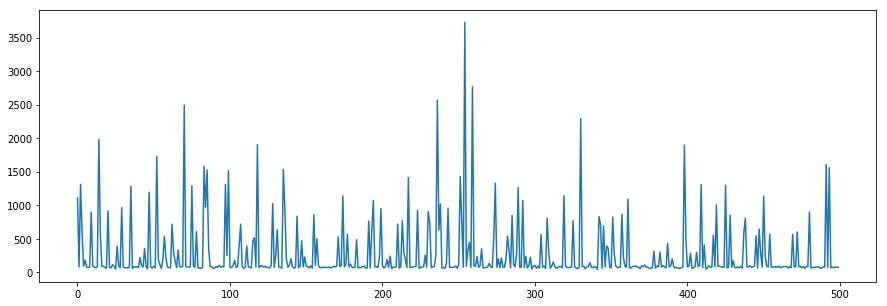

In [6]:
#################### check trend ###############
plt.figure(figsize=(15,5))
plt.plot(Y_orig[100,100,:500])

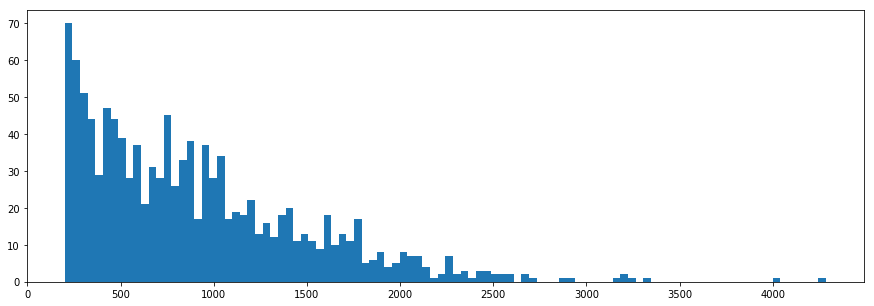

In [7]:
######### check gaussian white noise ########
plt.figure(figsize=(15,5));
plt.hist(Y_orig[50,0,Y_orig[50,0,:] > 200],bins=100);

In [64]:
########## normalize each pixel by the estimated noise
mean_ = Y_orig.mean(axis=2,keepdims=True);
sn_ = sup.noise_estimator(Y_orig);
sn_ = sn_.reshape(dims[0],dims[1],1)
Y_norm = (Y_orig - mean_)/sn_;

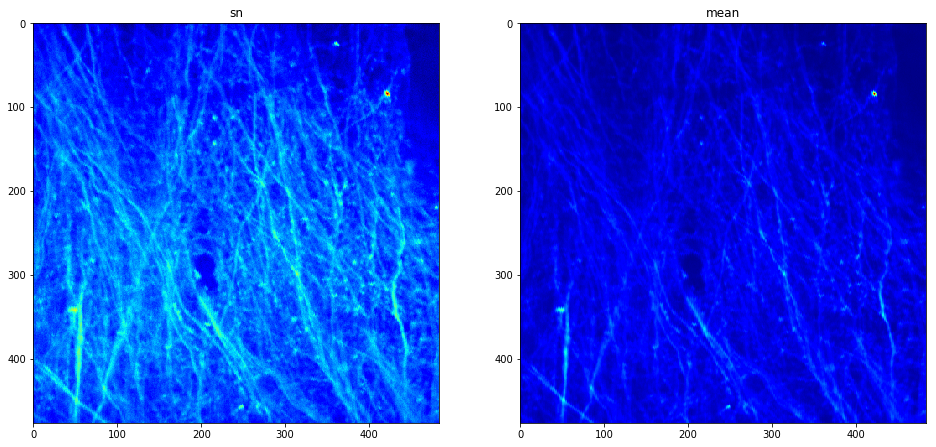

In [92]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(sn_[:,:,0],cmap="jet")
plt.title("sn")
plt.subplot(1,2,2)
plt.title("mean")
plt.imshow(mean_[:,:,0],cmap="jet")

In [66]:
np.savez(out_dir + "Y_orig_mean_sn.npz", mean_=mean_, sn_=sn_)

# high pass filter (may not need)

In [6]:
if True:
    Y_origr = Y_orig.reshape((np.prod(dims[:2]),dims[2]),order='F')
    fs = 10000.0
    cutoff = 100
    order = 6
    hps_1 = tfd.butter_highpass_filter(Y_origr, cutoff, fs, order)
    offset_1= Y_origr-hps_1

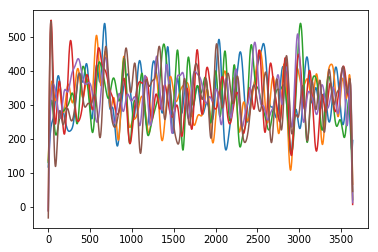

In [7]:
plt.plot(offset_1[:6,:].T);

In [45]:
Y_hp =  np.memmap(data_dir + "Y_hp.mmap", dtype='float32', mode='r',shape=(477,484,3640),order='F');

# wiener filter

In [116]:
Y_wf, _ = fdata.spatial_filter_image(Y_norm);

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000
first k pixels 5000
first k pixels 6000
first k pixels 7000
first k pixels 8000
first k pixels 9000
first k pixels 10000
first k pixels 11000
first k pixels 12000
first k pixels 13000
first k pixels 14000
first k pixels 15000
first k pixels 16000
first k pixels 17000
first k pixels 18000
first k pixels 19000
first k pixels 20000
first k pixels 21000
first k pixels 22000
first k pixels 23000
first k pixels 24000
first k pixels 25000
first k pixels 26000
first k pixels 27000
first k pixels 28000
first k pixels 29000
first k pixels 30000
first k pixels 31000
first k pixels 32000
first k pixels 33000
first k pixels 34000
first k pixels 35000
first k pixels 36000
first k pixels 37000
first k pixels 38000
first k pixels 39000
first k pixels 40000
first k pixels 41000
first k pixels 42000
first k pixels 43000
first k pixels 44000
first k pixels 45000
first k pixels 46000
first k pixels 47000
first

In [119]:
Cno = sup.local_correlations_fft(Y_norm);
Cnw = sup.local_correlations_fft(Y_wf);
Cn_wr = sup.local_correlations_fft(Y_norm - Y_wf);

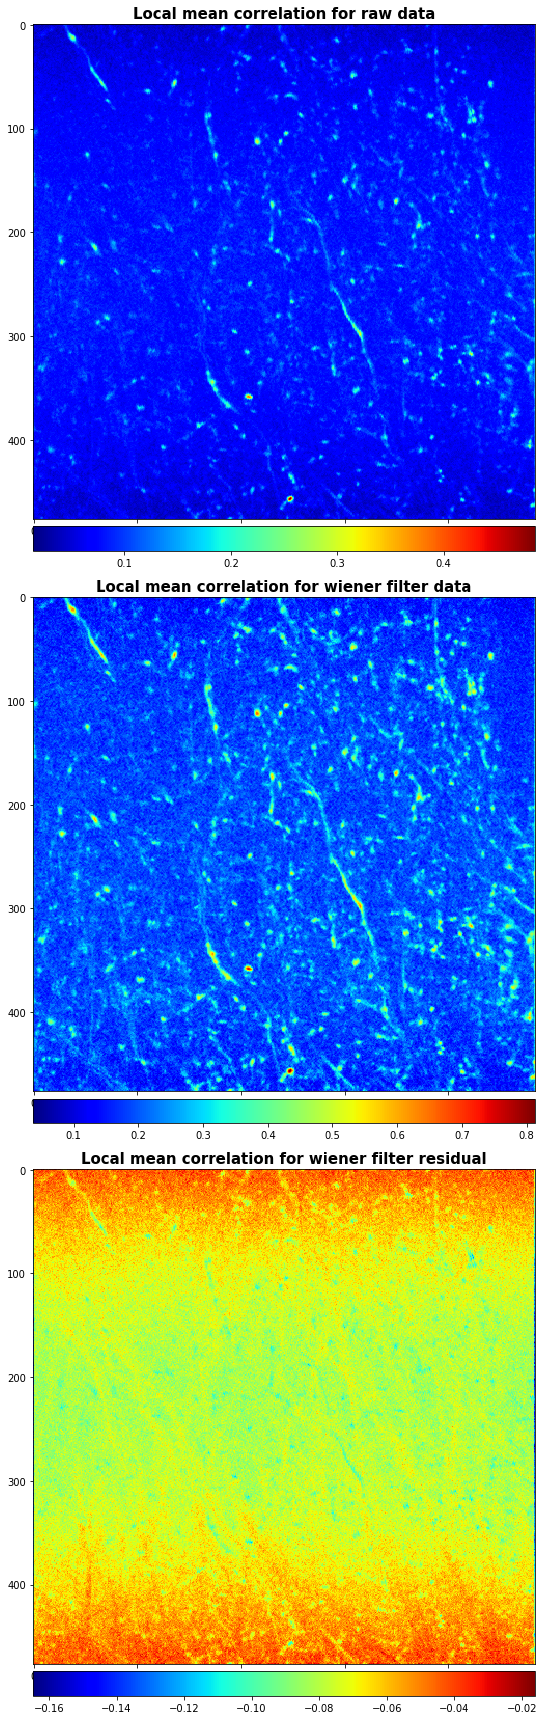

In [120]:
########### check correlation image ######################
fig = plt.figure(figsize=(8,24))
ax1 = plt.subplot(3,1,1)
sup.show_img(ax1, Cno);
ax1.set(title="Local mean correlation for raw data")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")
ax2 = plt.subplot(3,1,2)
sup.show_img(ax2, Cnw);
ax2.set(title="Local mean correlation for wiener filter data")
ax2.title.set_fontsize(15)
ax2.title.set_fontweight("bold")
ax3 = plt.subplot(3,1,3)
sup.show_img(ax3, Cn_wr);
ax3.set(title="Local mean correlation for wiener filter residual")
ax3.title.set_fontsize(15)
ax3.title.set_fontweight("bold")
plt.tight_layout();
fig.savefig("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/wf_corr_comp.pdf")

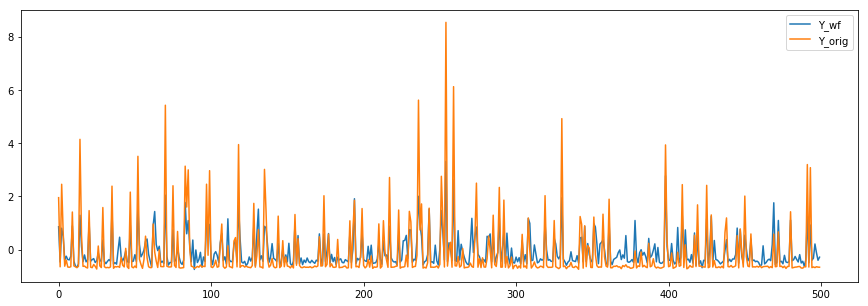

In [125]:
########### check trace #####################
#################### check trend ###############
plt.figure(figsize=(15,5))
plt.plot(Y_wf[100,100,:500],label="Y_wf")
plt.plot(Y_norm[100,100,:500],label="Y_orig")
plt.legend()

In [44]:
Y_wf =  np.memmap(out_dir + "Y_wf.mmap", dtype='float32', mode='r',shape=(477,484,3640),order='F')

# motion correction

# denoise

In [163]:
nblocks = [15,15]

In [164]:
W_ = tgrid.split_image_into_blocks(Y_wf,nblocks=nblocks)

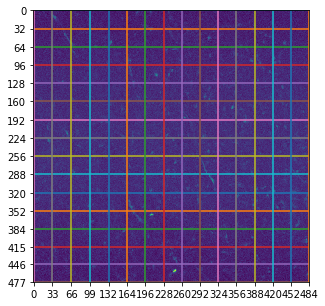

In [165]:
uplot.tiling_grid_plot(Y_wf,nblocks)

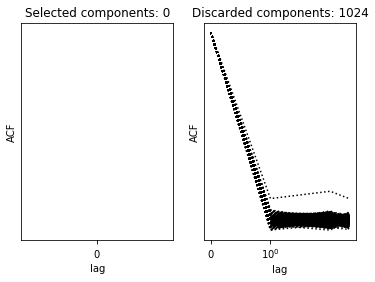

change to lower confidence level


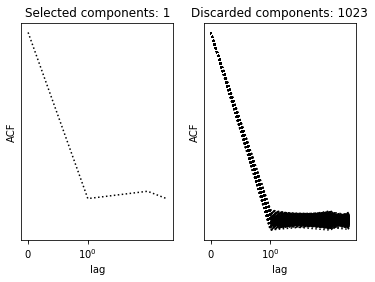

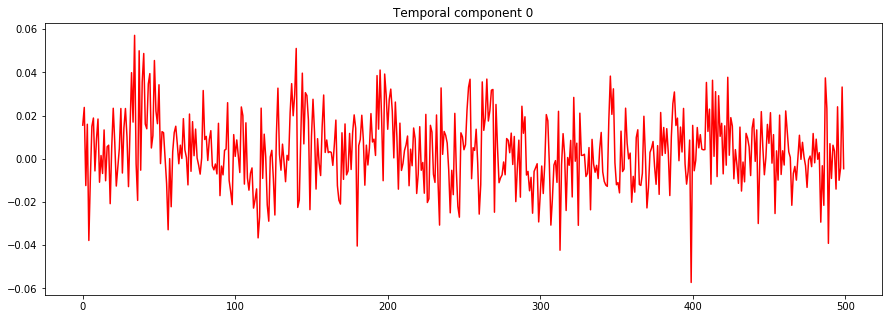

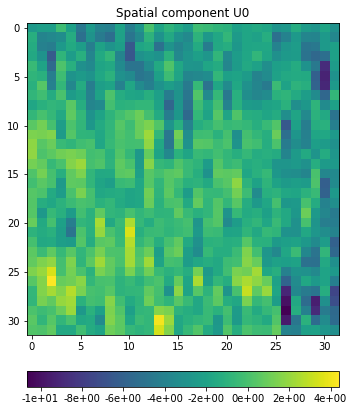

Initialize iterations with 1 components
solve V(i) = argmin_W ||D^2 W||_1 
	 st ||V_i-W||_2<fudge_factor*sigma_i*sqrt(T)
Max number of greedy loops: 20 (relative convergence)
U = Y*pinv(V)
*Iteration 0 part (1) with 1 components
solve V(i)
noise
[0.00777377]
Noise range is 7.774e-03 7.774e-03
lambda
[0.00707567]


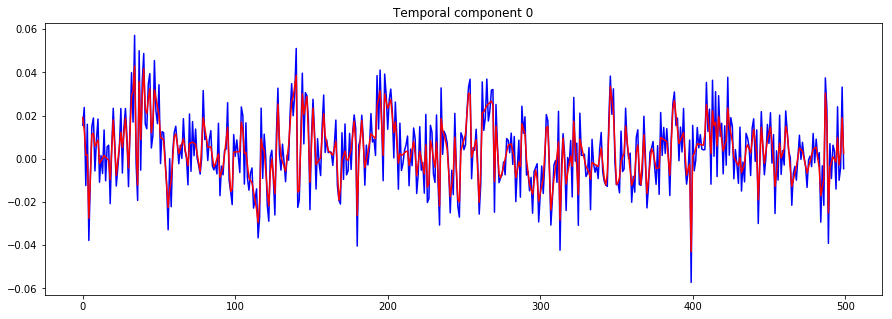

solve U(j)


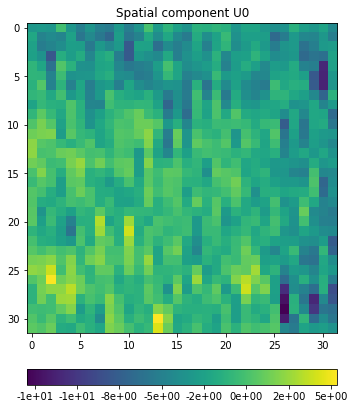

Iteration 0: begin greedy loops
	Iteration 0 loop 0 with 1 components
	update V_i in closed form


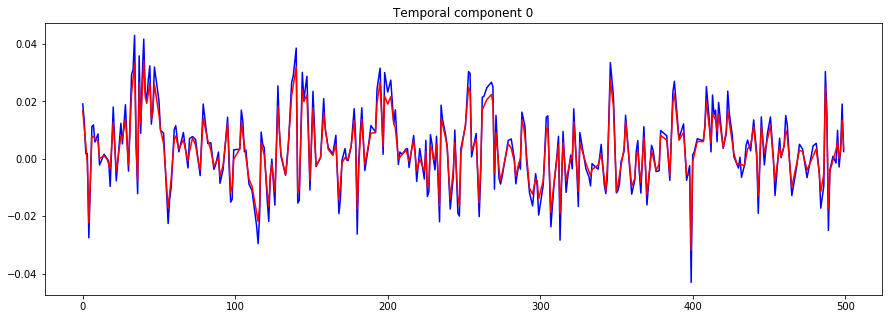

	Iteration 0 loop 0 error (1.460e+06+1.246e+03+0.000e+00)=1.461e+06
	update U_j in closed form/regression
	Iteration 0 loop 0 error (1.460e+06+1.246e+03+0.000e+00)=1.461e+06
	Iteration 0 loop 1 with 1 components
	update V_i in closed form


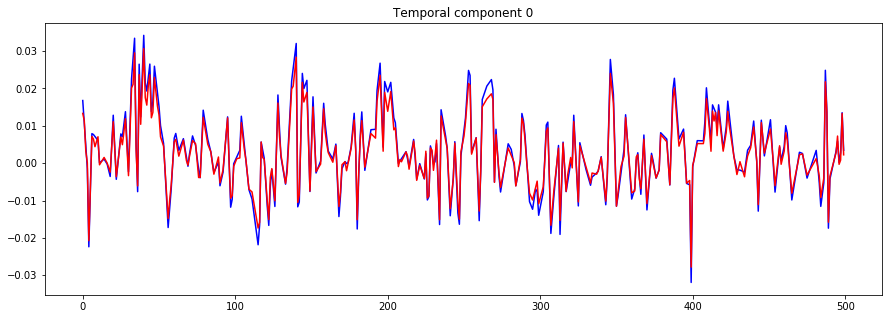

	Iteration 0 loop 1 error (1.460e+06+1.228e+03+0.000e+00)=1.461e+06
	update U_j in closed form/regression
	Iteration 0 loop 1 error (1.460e+06+1.228e+03+0.000e+00)=1.461e+06
	Iteration 0 loop 2 with 1 components
	update V_i in closed form


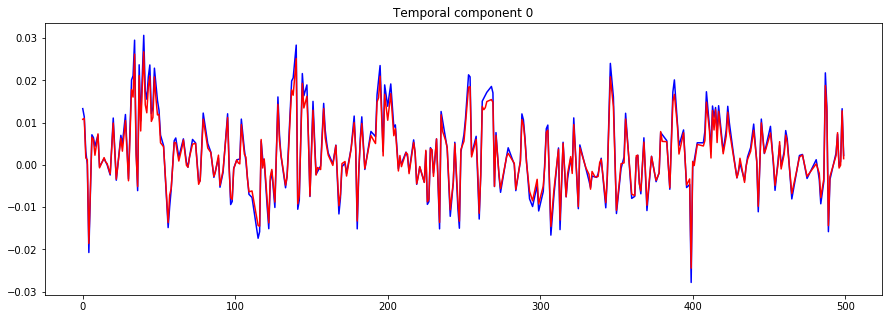

	Iteration 0 loop 2 error (1.460e+06+1.224e+03+0.000e+00)=1.461e+06
	update U_j in closed form/regression
	Iteration 0 loop 2 error (1.460e+06+1.224e+03+0.000e+00)=1.461e+06
	Iteration 0 loop 3 with 1 components
	update V_i in closed form


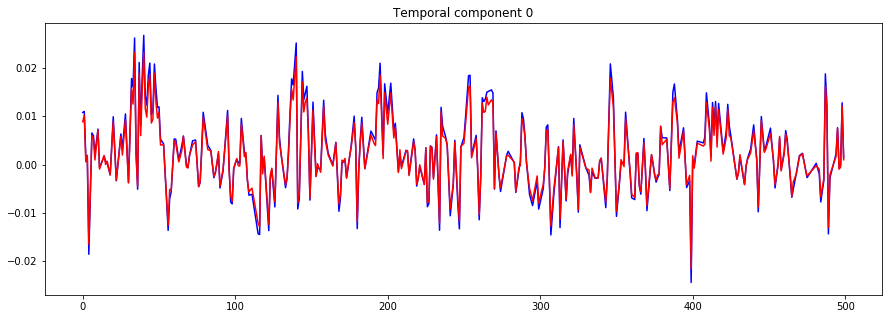

	Iteration 0 loop 3 error (1.460e+06+1.209e+03+0.000e+00)=1.461e+06
	update U_j in closed form/regression
	Iteration 0 loop 3 error (1.459e+06+1.209e+03+0.000e+00)=1.461e+06
	Iteration 0 loop 4 with 1 components
	update V_i in closed form


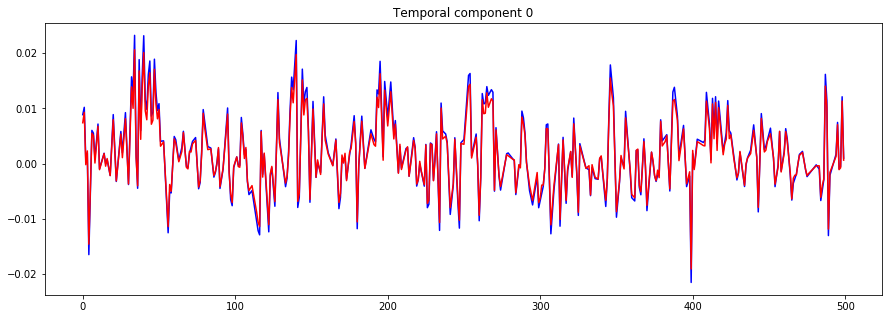

	Iteration 0 loop 4 error (1.459e+06+1.182e+03+0.000e+00)=1.461e+06
	update U_j in closed form/regression
	Iteration 0 loop 4 error (1.459e+06+1.182e+03+0.000e+00)=1.460e+06
	Iteration 0 loop 5 with 1 components
	update V_i in closed form


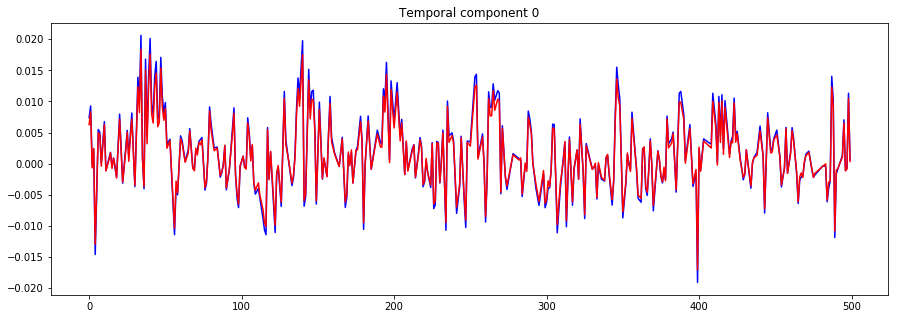

	Iteration 0 loop 5 error (1.459e+06+1.145e+03+0.000e+00)=1.460e+06
	update U_j in closed form/regression
	Iteration 0 loop 5 error (1.459e+06+1.145e+03+0.000e+00)=1.460e+06
	Iteration 0 loop 6 with 1 components
	update V_i in closed form


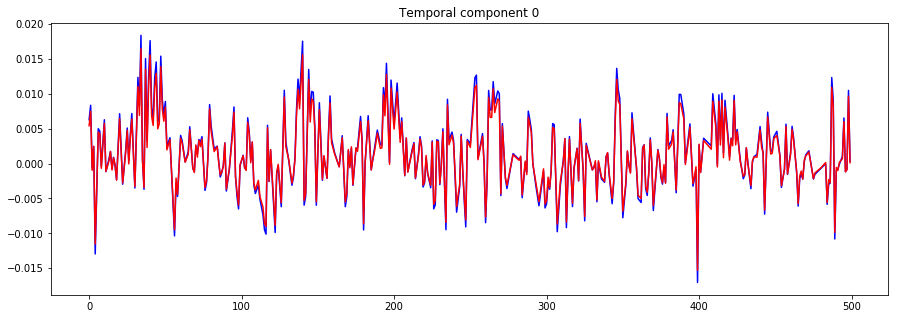

	Iteration 0 loop 6 error (1.459e+06+1.101e+03+0.000e+00)=1.460e+06
	update U_j in closed form/regression
	Iteration 0 loop 6 error (1.459e+06+1.101e+03+0.000e+00)=1.460e+06
	Iteration 0 ended at loop 6 - no significant updates


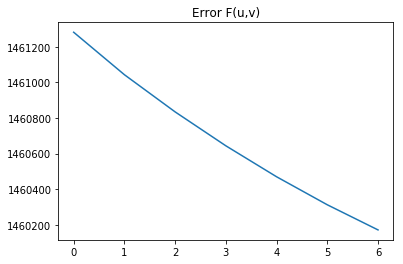

*Iteration 0 part (2) with 1 components


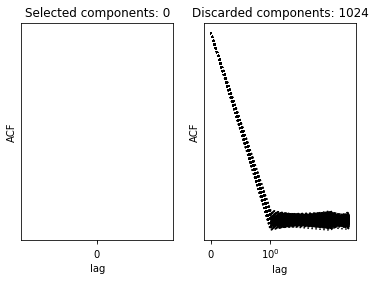

Final number of components 1
Running final update after 0 iterations
	solve V(j)
Solve V_[0])
noise
[0.00205727]
Noise range is 2.057e-03 2.057e-03


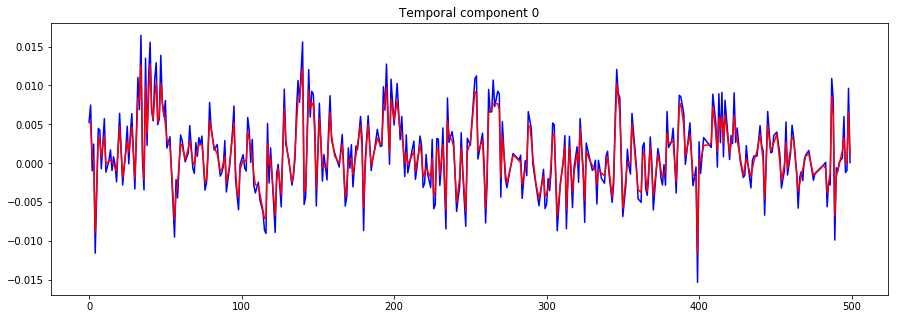

	solve U(j)
	Regress for V(j)


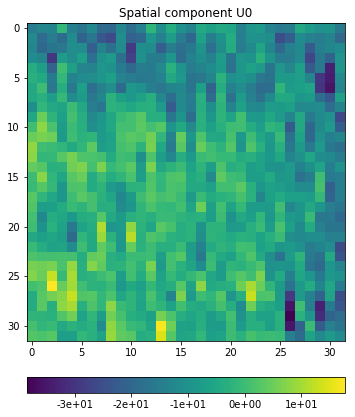

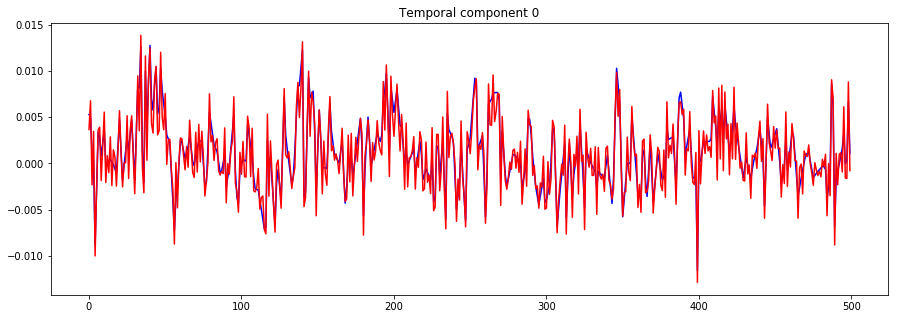

	M	rank: 1	run_time: 39.627582


In [223]:
b,a = gpca.denoise_patch(W_[14][:,:,:],
                               maxlag=3,confidence=0.99,
                               greedy=True,fudge_factor=0.5,
                               mean_th_factor=2,mean_th_factor2=1.15,U_update=False,
                             verbose=True,plot_en=True,min_rank=1,max_num_iters=5,
                             max_num_components=50)

# load results, plot and make movie

In [139]:
### load Yd and do plots #######
data_dir='/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/'

In [140]:
out_dir ='/Users/zhd/Desktop/Research/Project/Dendritic data/result/first_try/'

In [13]:
Yd =  np.load(data_dir + "Yd_single.npy")

In [225]:
Cnd = sup.local_correlations_fft(Yd);

In [228]:
import caiman as cm

In [229]:
cm.movie(Yd[:100,:100,:].transpose(2,0,1)).play(magnification=5)

KeyboardInterrupt: 

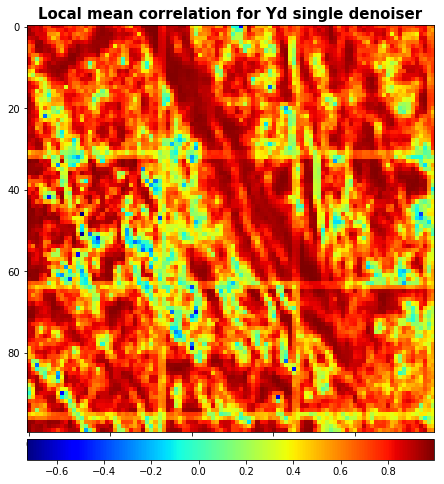

In [227]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
sup.show_img(ax1, Cnd[:100,:100]);
ax1.set(title="Local mean correlation for Yd single denoiser")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")

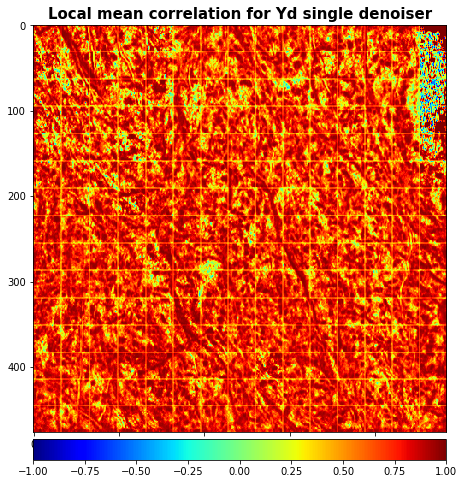

In [226]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
sup.show_img(ax1, Cnd);
ax1.set(title="Local mean correlation for Yd single denoiser")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")

In [220]:
ranks = np.load(data_dir + "ranks_single.npy")

In [221]:
dimsMc = np.load(data_dir + "dimsMc.npy")

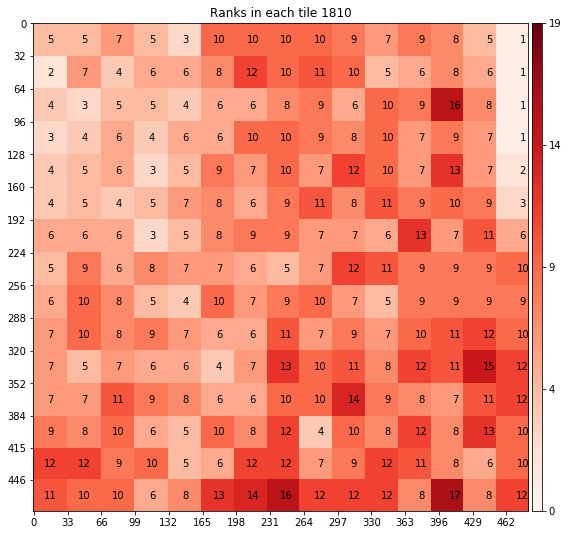

In [222]:
#plt.figure(figsize=(8,8));
fig = uplot.cn_ranks_plot(dimsMc, ranks, dims,
                  nblocks=[15, 15],
                  list_order='C',
                  exclude_max=True,
                  max_rank=100);
fig.savefig(data_dir + "ranks_single.pdf")

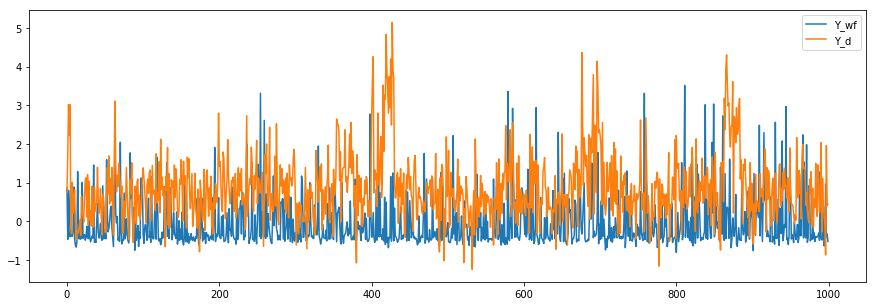

In [21]:
########### check trace #####################
plt.figure(figsize=(15,5))
plt.plot(Y_wf[100,100,:1000],label="Y_wf")
plt.plot(10*Yd[100,100,:1000]+1,label="Y_d")
plt.legend()

In [22]:
########### load 4x results ###################
W_rs =  np.load(data_dir + "W_rs.npy")
W_cs =  np.load(data_dir + "W_cs.npy")
W_rcs =  np.load(data_dir + "W_rcs.npy")

In [23]:
ak0 = np.load(data_dir + "ak0.npy")
ak1 = np.load(data_dir + "ak1.npy")
ak2 = np.load(data_dir + "ak2.npy")
ak3 = np.load(data_dir + "ak3.npy")

In [24]:
Yd4 = (Yd*ak0[:,:,np.newaxis] + W_rs*ak1[:,:,np.newaxis] + W_cs*ak2[:,:,np.newaxis] + W_rcs*ak3[:,:,np.newaxis])

In [25]:
Yd4 = Yd4/(ak0+ak1+ak2+ak3)[:,:,np.newaxis]

In [47]:
Yd4 = np.memmap("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/Yd_4x.mmap", dtype='float32', mode='r',shape=(477,484,3640),order='F');

In [31]:
Yd4 = Yd4*info["sn_"] + info["mean_"] #+ offset_1[:,:,100:-100];

In [141]:
Yd4 = np.memmap("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/Yd_4x_fin.mmap", dtype='float32', mode='r',shape=(477,484,3640),order='F');

In [175]:
Yt = np.memmap("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/Yt_4x_fin.mmap", dtype='float32', shape=(477,484,3640),mode='r',order='F');

In [176]:
Cnt = sup.local_correlations_fft(Yt);

In [52]:
Cnd4 = sup.local_correlations_fft(Yd4)#[:100,:100,:]);

In [53]:
Cno = sup.local_correlations_fft(Y_wf)#[:100,:100,:]);

In [54]:
Cnr = sup.local_correlations_fft(Y_wf - Yd4)#[:100,:100,:] - Yd4[:100,:100,:]);

In [182]:
np.savez(data_dir + "corr_mat_denoise.npz", Cnd4 = Cnd4, Cno=Cno, Cnr=Cnr,Cnt=Cnt);

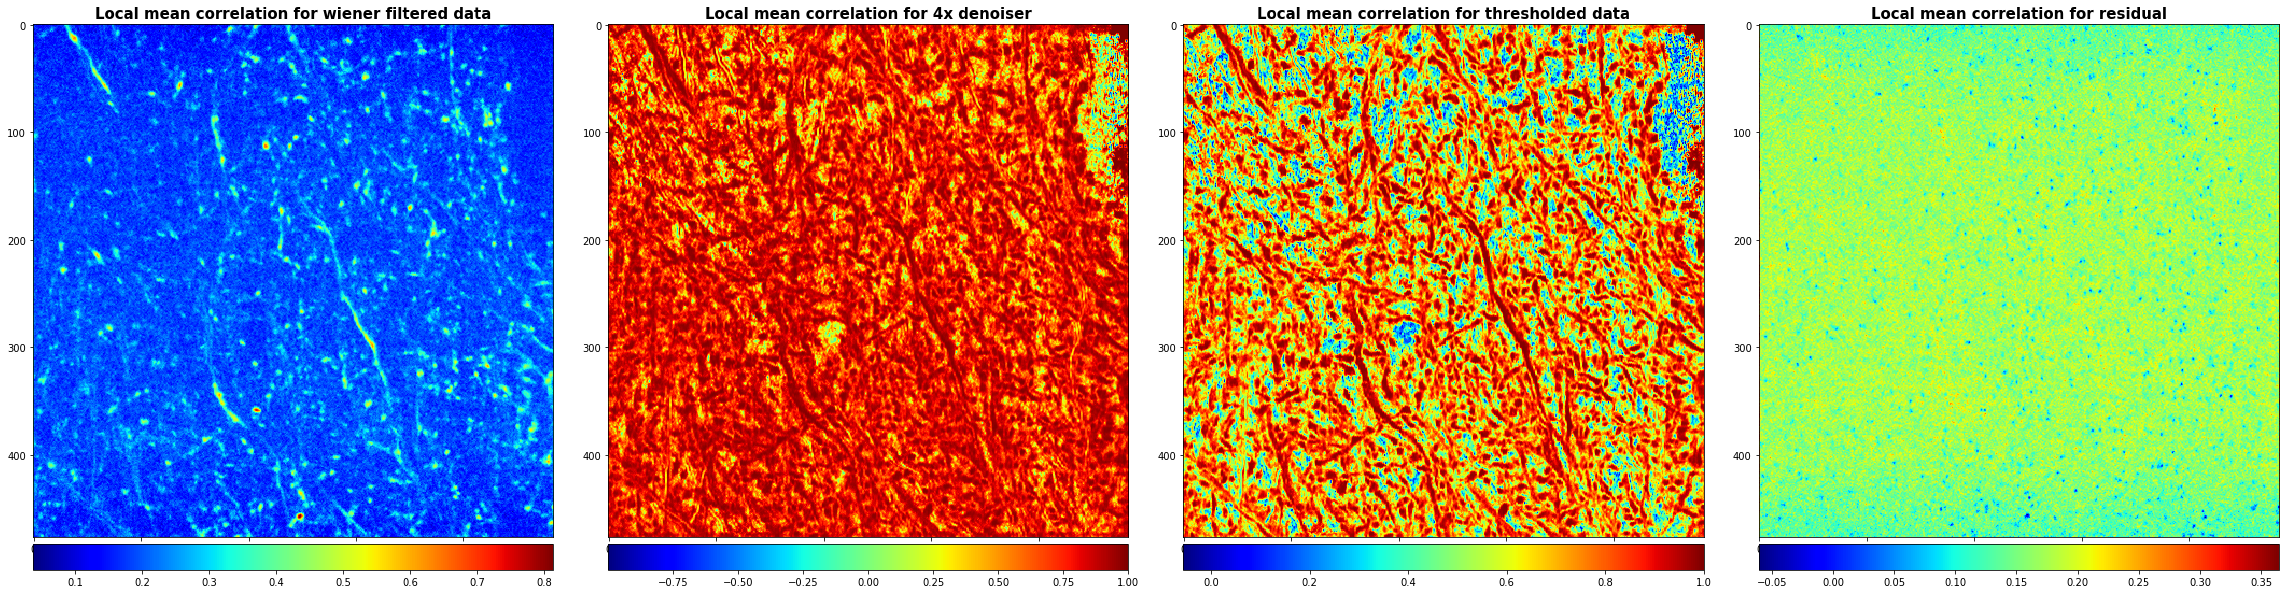

In [178]:
fig = plt.figure(figsize=(32,8))
ax1 = plt.subplot(1,4,1)
sup.show_img(ax1, Cno);
ax1.set(title="Local mean correlation for wiener filtered data")
ax1.title.set_fontsize(15)
ax1.title.set_fontweight("bold")
ax2 = plt.subplot(1,4,2)
sup.show_img(ax2, Cnd4)#[:100,:100]);
ax2.set(title="Local mean correlation for 4x denoiser")
ax2.title.set_fontsize(15)
ax2.title.set_fontweight("bold")
ax3 = plt.subplot(1,4,3)
sup.show_img(ax3, Cnt);
ax3.set(title="Local mean correlation for thresholded data")
ax3.title.set_fontsize(15)
ax3.title.set_fontweight("bold")
ax4 = plt.subplot(1,4,4)
sup.show_img(ax4, Cnr);
ax4.set(title="Local mean correlation for residual")
ax4.title.set_fontsize(15)
ax4.title.set_fontweight("bold")
plt.tight_layout();
fig.savefig("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/corr_comp_denoise.pdf")

In [124]:
Yt = sup.threshold_data(Yd4[:100,:100,:]);

In [144]:
Yo_1 = Y_orig[:,:,:].transpose([2,0,1]);
Yd_1 = Yd4[:,:,:].transpose([2,0,1]);
#Yt_1 = Yt[:,:,:].transpose(2,0,1);
Rt_1 = Yo_1 - Yd_1;
Yo_1 = Yo_1 - Yo_1.min(axis=0, keepdims=True);
Yd_1 = Yd_1 - Yd_1.min(axis=0, keepdims=True);

In [145]:
Yo_1 = (Yo_1 - Yo_1.min())/(Yo_1.max() - Yo_1.min())*255;
#Yt_1 = (Yt_1 - Yt_1.min())/(Yt_1.max() - Yt_1.min())*255
Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min())*255
Rt_1 = (Rt_1 - Rt_1.min())/(Rt_1.max() - Rt_1.min())*255

In [146]:
#plt.hist(Yo_1.ravel());
Yo_1 = np.clip(Yo_1,0,102);
#Yo_1 = np.clip(Yo_1,0,75);

In [148]:
#plt.hist(np.clip(Yd_1,0,25).ravel());
Yd_1 = np.clip(Yd_1,0,15);
#Yd_1 = np.clip(Yd_1,0,25);

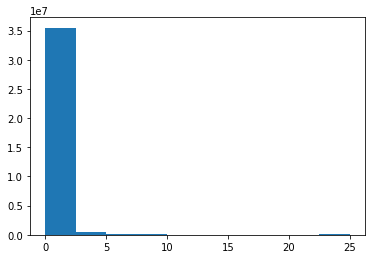

In [129]:
plt.hist(np.clip(Yt_1,0,25).ravel());
#Yd_1 = np.clip(Yd_1,0,15);
Yt_1 = np.clip(Yt_1,0,25);

In [149]:
#plt.hist(np.clip(Rt_1,35,100).ravel());
Rt_1 = np.clip(Rt_1,25,125);
#Rt_1 = np.clip(Rt_1,35,100);

In [150]:
Yo_1 = (Yo_1 - Yo_1.min())/(Yo_1.max() - Yo_1.min())*255;
Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min())*255
Rt_1 = (Rt_1 - Rt_1.min())/(Rt_1.max() - Rt_1.min())*255
#Yt_1 = (Yt_1 - Yt_1.min())/(Yt_1.max() - Yt_1.min())*255

In [151]:
Frame=np.concatenate([Yo_1,Yd_1,Rt_1],axis=2);

In [152]:
T = dims[2];

In [153]:
import skvideo.io
outputdata = Frame
writer = skvideo.io.FFmpegWriter("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/axon_imaging.mp4")
for i in range(T):
    writer.writeFrame(outputdata[i, :, :])
writer.close()

In [23]:
Frame2=np.concatenate([Yo_1[:,:100,:100],Yd_1[:,:100,:100],Rt_1[:,:100,:100]],axis=2);

In [134]:
import skvideo.io
outputdata = Frame
writer = skvideo.io.FFmpegWriter("/Users/zhd/Desktop/Research/Project/Dendritic data/result/denoise/axon_imaging_patch_t.mp4")
for i in range(T):
    writer.writeFrame(outputdata[i, :, :])
writer.close()